# Final Project

In [2]:
# Install required packages
!pip install -r requirements.txt

In [1]:
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import svm
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    plot_confusion_matrix,
    PrecisionRecallDisplay,
    precision_recall_curve,
    RocCurveDisplay,
    roc_auc_score,
)
from sklearn.metrics.cluster import (
    adjusted_rand_score,
    contingency_matrix,
    v_measure_score,
)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import (
    cross_val_score,
    HalvingGridSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")
np.random.seed(123)  # For reproducibility

In [3]:
df = pd.read_csv("./data/winequality-white.csv", sep=";")

# See the number of rows and columns
print("Rows, columns: " + str(df.shape))

df.head()

Rows, columns: (4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


The description of the attributes are as follows, with the input variables (based on physiochemical tests):  
1. fixed acidity (tartaric acid - g / dm^3)  
most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
2. volatile acidity (acetic acid - g / dm^3)  
the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
3. citric acid (g / dm^3)  
found in small quantities, citric acid can add ‘freshness’ and flavor to wines
4. residual sugar (g / dm^3)  
the amount of sugar remaining after fermentation stops, it’s rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
5. chlorides (sodium chloride - g / dm^3)  
the amount of salt in the wine
6. free sulfur dioxide (mg / dm^3)  
the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine
7. total sulfur dioxide (mg / dm^3)  
amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine
8. density (g / cm^3)  
the density of wine is close to that of water depending on the percent alcohol and sugar content
9. pH  
describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale
10. sulphates (potassium sulphate - g / dm3)  
a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant
11. alcohol (% by volume)  
the percent alcohol content of the wine

Output variable (based on sensory data):   
12. quality (score between 0 and 10)  

## EDA

In [31]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [4]:
# Missing Values
print(df.isna().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


There are 11 input features and no missing values. Next, I will explore the distribution of the features.

### Distplot

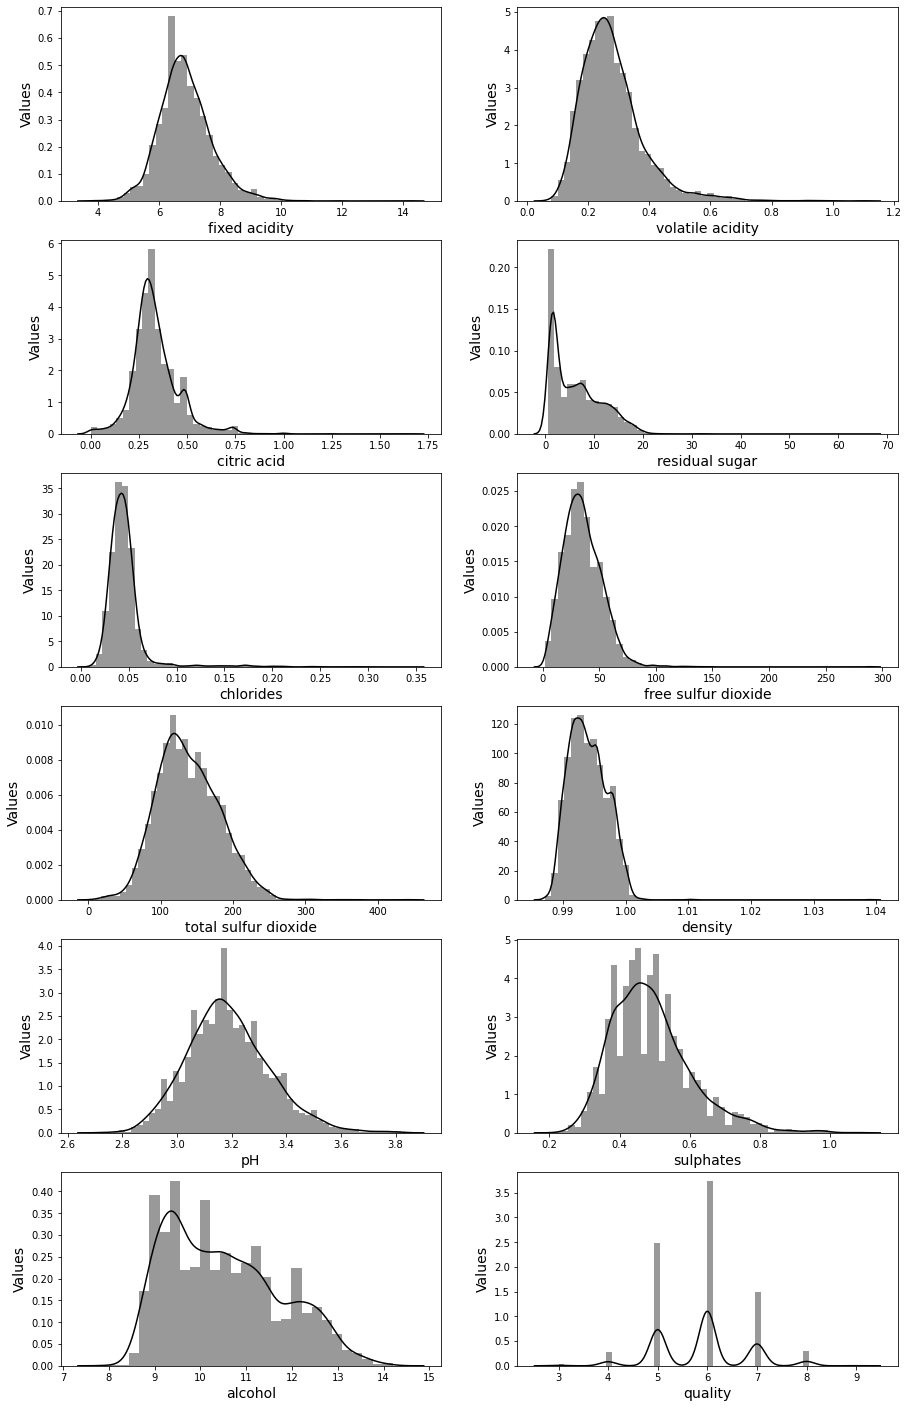

In [15]:
plt.figure(figsize=(15, 25))
plot_num = 1

for column in df:
    if plot_num < 13:
        ax = plt.subplot(6, 2, plot_num)
        sns.distplot(df[column], color="black")
        plt.xlabel(column, fontsize=14)
        plt.ylabel("Values", fontsize=14)
    plot_num += 1
plt.show()

Most features follow a normal distribution albeit skewed.  
There is a high number of low `residual_sugar` values.

### Bivariate Analysis
I have selected a few columns based on their statistical description and common interpretation to perform an analysis against the target variable (quality).

**Volatile acidity by wine quality**

<AxesSubplot:xlabel='quality', ylabel='volatile acidity'>

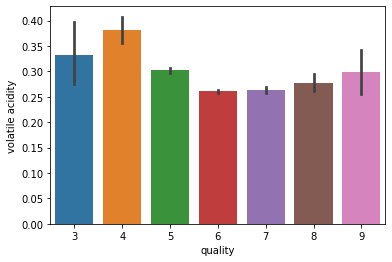

In [8]:
sns.barplot(x="quality", y="volatile acidity", data=df)

It is interesting to note that volatile acidity drops and slighty increases with higher wine qualities.

**Citric acid by wine quality**

<AxesSubplot:xlabel='quality', ylabel='citric acid'>

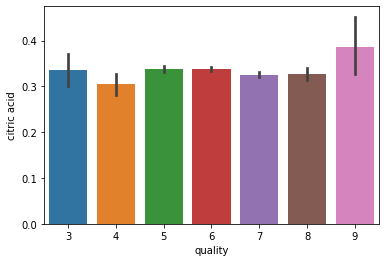

In [27]:
sns.barplot(x="quality", y="citric acid", data=df)

Citric acid sharply increases for the highest quality. This suggests that the highest quality wine has its taste enhanced.

**Residual sugar by wine quality**

<AxesSubplot:xlabel='quality', ylabel='residual sugar'>

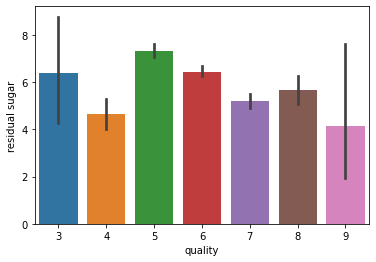

In [25]:
sns.barplot(x="quality", y="residual sugar", data=df)

Residual sugar appears to decrease with higher wine quality. However the highest quality has the biggest error bar.

**Sulphates by wine quality**

<AxesSubplot:xlabel='quality', ylabel='sulphates'>

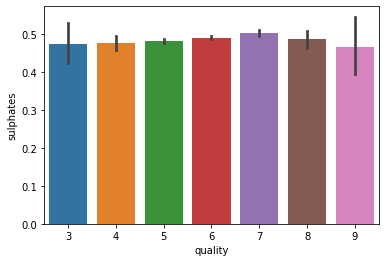

In [26]:
sns.barplot(x="quality", y="sulphates", data=df)

There is a downward trend of sulphate level in higher quality wines. This is inline with general consensus that the better the wine, the lower the sulphate levels.

**Alcohol content by wine quality**

<AxesSubplot:xlabel='quality', ylabel='alcohol'>

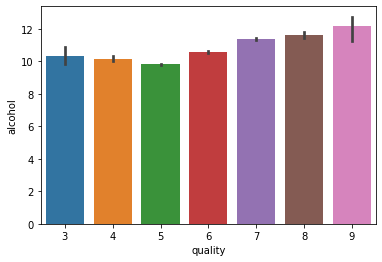

In [9]:
sns.barplot(x="quality", y="alcohol", data=df)

Alcohol level in the wines begin to increase as the quality of the wine increases from 6.

**Chlorides by wine quality**

<AxesSubplot:xlabel='quality', ylabel='chlorides'>

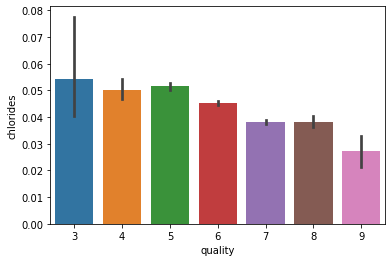

In [30]:
sns.barplot(x="quality", y="chlorides", data=df)

As wine quality increases, the amount of salt in the wine decreases.

**Residual sugar, Alcohol, and Density**

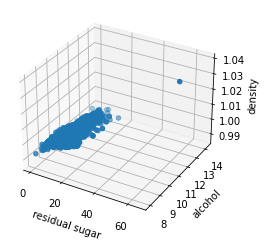

In [49]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(df["residual sugar"], df["alcohol"], df["density"])
ax.set_xlabel("residual sugar")
ax.set_ylabel("alcohol")
ax.set_zlabel("density")
plt.show()

As density decreases, alcohol content decreases while residual sugar increases. This suggests that sugar is denser than alcohol. From a chemistry perspective, ethanol is less dense than water and sugar is the dominant component of density of fermented grapes. This [article](https://daily.sevenfifty.com/understanding-the-role-of-sugar-in-wine/) discusses the role of suagr in wines at a great length.

### Correlation

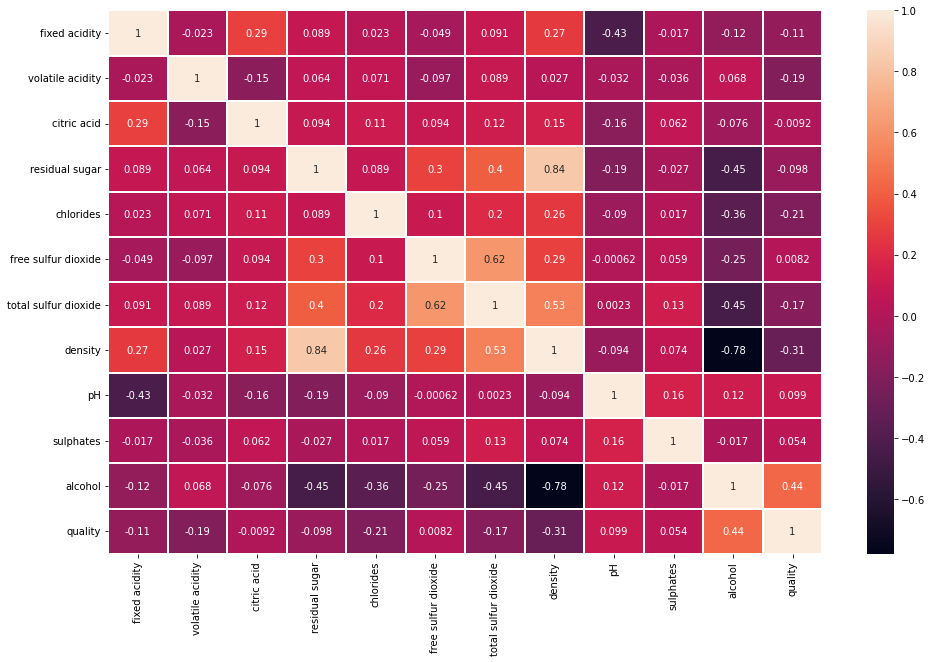

In [5]:
plt.figure(figsize=(16, 10))

correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, linewidths=0.2)
plt.show()

Visually, it can be observed that 'residual_sugar' and 'density' are highly positively correlated. 'density' is also highly negatively correlated with 'alcohol'. A rule of thumb is, that the lower the percentage of alcohol, the more sugar is still in the fluid = heavier liquid. This can also be observed from the pairplot below.  

The feature 'density' can potentially be removed as its information can be represented by its correlations. Also its values just range from 0.987 to 1.039.

### Label Binarizing

In this step, I will convert the labels from a current range of 3-9 to 1 or 0 based on a threshold.

In [4]:
df["quality"].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

array([[<AxesSubplot:title={'center':'quality'}>]], dtype=object)

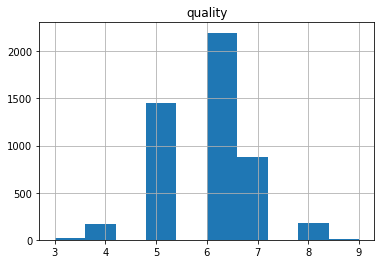

In [5]:
df.hist(column="quality")

As this project compares the effectiveness of different classification techniques, I will transform the output variable to a binary output.  
For this problem, I defined ‘good quality’ with a quality score of 7 or higher, and if it had a score of less than 7, it was deemed ‘bad quality’.

In [4]:
# Create Classification version of target variable
df_bin_label = df.copy()
df_bin_label["goodquality"] = [1 if x >= 7 else 0 for x in df_bin_label["quality"]]

In [5]:
# See proportion of good vs bad wines
df_bin_label["goodquality"].value_counts()

0    3838
1    1060
Name: goodquality, dtype: int64

array([[<AxesSubplot:title={'center':'goodquality'}>]], dtype=object)

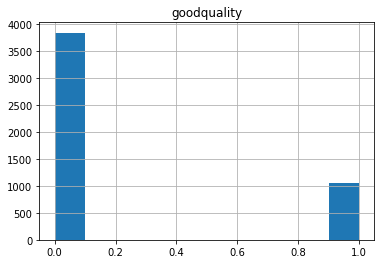

In [6]:
df_bin_label.hist(column="goodquality")

There is a class imbalance of approximately 3.6X more bad quality wines over good quality. Stratifying the K-Fold cross validation and train-test split will be used to account for the imbalance.  

In addition, random undersampling and SMOTE can be used to balance the classes. I will also utilize the class_weight parameter to create balanced models.

**Wines Descriptions by Good/Bad Quality**

In [7]:
df_goodquality = df_bin_label[df_bin_label["goodquality"] == 1]
df_goodquality.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,goodquality
count,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.0
mean,6.725142,0.265349,0.326057,5.261509,0.038160,34.550472,125.245283,0.992412,3.215132,0.500142,11.416022,7.174528,1.0
std,0.768798,0.094097,0.080288,4.290845,0.011145,13.797146,32.724848,0.002772,0.157185,0.133044,1.255209,0.391978,0.0
min,3.900000,0.080000,0.010000,0.800000,0.012000,5.000000,34.000000,0.987110,2.840000,0.220000,8.500000,7.000000,1.0
25%,6.200000,0.190000,0.280000,1.800000,0.031000,25.000000,101.000000,0.990500,3.100000,0.400000,10.700000,7.000000,1.0
50%,6.700000,0.250000,0.310000,3.875000,0.037000,33.000000,122.000000,0.991730,3.200000,0.480000,11.500000,7.000000,1.0
75%,7.200000,0.320000,0.360000,7.400000,0.044000,42.000000,146.000000,0.993605,3.320000,0.580000,12.400000,7.000000,1.0
max,9.200000,0.760000,0.740000,19.250000,0.135000,108.000000,229.000000,1.000600,3.820000,1.080000,14.200000,9.000000,1.0


In [8]:
df_notgoodquality = df_bin_label[df_bin_label["goodquality"] == 0]
df_notgoodquality.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,goodquality
count,3838.000000,3838.000000,3838.000000,3838.000000,3838.000000,3838.000000,3838.000000,3838.000000,3838.000000,3838.000000,3838.000000,3838.000000,3838.0
mean,6.890594,0.281802,0.336438,6.703478,0.047875,35.517327,141.982934,0.994474,3.180847,0.487004,10.265215,5.519802,0.0
std,0.860108,0.102293,0.129959,5.225048,0.023548,17.787825,44.145402,0.002894,0.148414,0.108167,1.100576,0.604905,0.0
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987220,2.720000,0.230000,8.000000,3.000000,0.0
25%,6.300000,0.220000,0.260000,1.700000,0.037000,23.000000,111.000000,0.992320,3.080000,0.410000,9.400000,5.000000,0.0
50%,6.800000,0.270000,0.320000,6.000000,0.045000,34.000000,140.000000,0.994380,3.170000,0.470000,10.000000,6.000000,0.0
75%,7.400000,0.320000,0.400000,10.400000,0.051000,47.000000,173.000000,0.996570,3.267500,0.540000,11.000000,6.000000,0.0
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.810000,1.060000,14.000000,6.000000,0.0


By looking into the details, we can see that good quality wines have higher levels of alcohol on average, have a lower volatile acidity on average, higher levels of sulphates on average, and lower levels of residual sugar on average.  

The densities of both good and not good quality wines are similar.

### Pairplot
Viewing the distribution of numerical features. I have chosen a subset of numerical features to plot against the binarized label.

<Figure size 1440x2520 with 0 Axes>

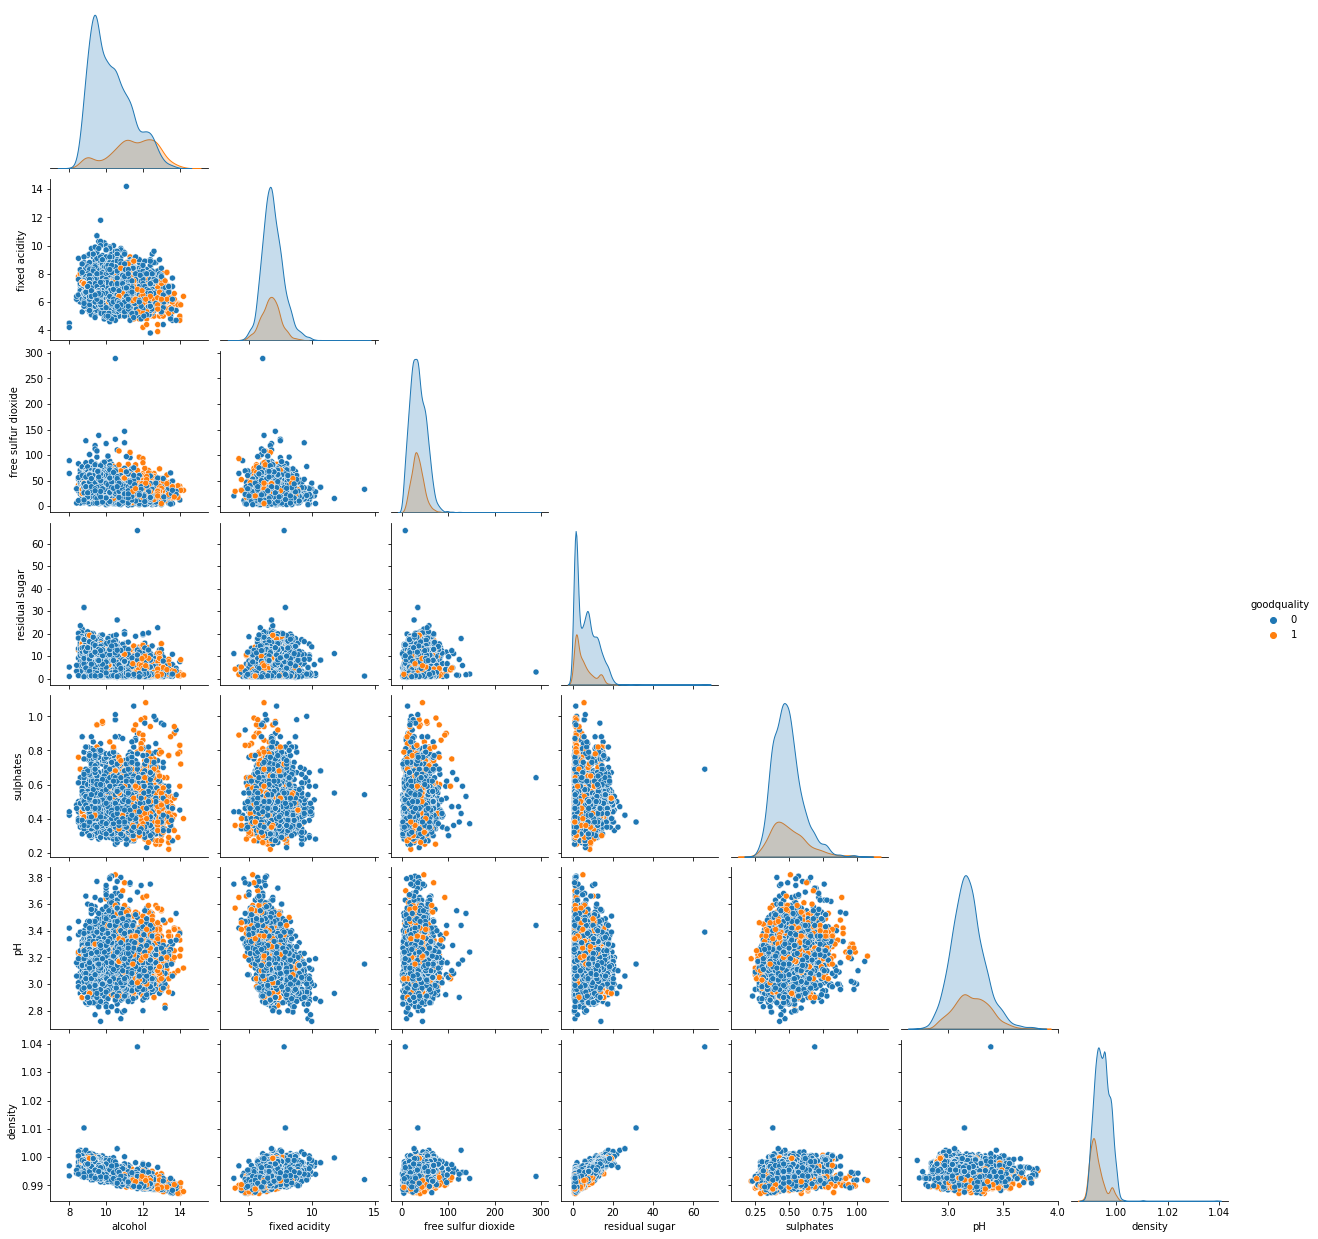

In [39]:
df_subset = df_bin_label[
    [
        "alcohol",
        "fixed acidity",
        "free sulfur dioxide",
        "residual sugar",
        "sulphates",
        "pH",
        "density",
        "goodquality",
    ]
]
plt.figure(figsize=(20, 35))
sns.pairplot(df_subset, hue="goodquality", corner=True)

The selected subset of features have similar distributions with respect to the target where the good quality wines are within the 0 class. In addition, there are also outliers present in the numerical features.

### Boxplot
of selected features by binarized label. Good quality wines is equal to label 1.

<AxesSubplot:xlabel='goodquality', ylabel='alcohol'>

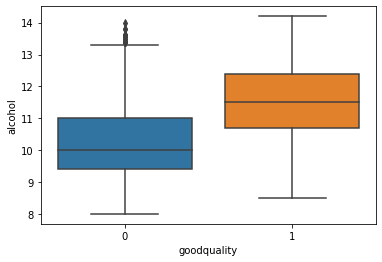

In [35]:
sns.boxplot(x="goodquality", y="alcohol", data=df_bin_label)

Good quality wines have a much higher range and mean average of alcohol content.

<AxesSubplot:xlabel='goodquality', ylabel='residual sugar'>

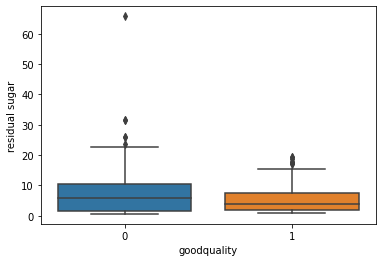

In [34]:
sns.boxplot(x="goodquality", y="residual sugar", data=df_bin_label)

Good quality wines have a lesser threshold of residual sugar.

<AxesSubplot:xlabel='goodquality', ylabel='chlorides'>

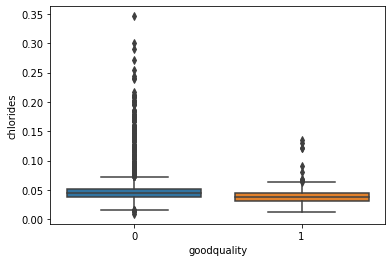

In [36]:
sns.boxplot(x="goodquality", y="chlorides", data=df_bin_label)

Good quality wines have much lesser outliers in chlorides.

<AxesSubplot:xlabel='goodquality', ylabel='sulphates'>

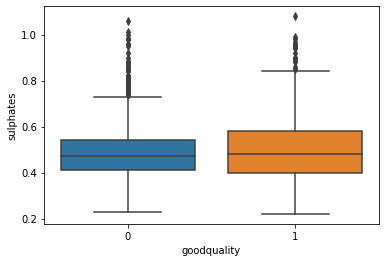

In [37]:
sns.boxplot(x="goodquality", y="sulphates", data=df_bin_label)

Good quality wines have a similar median with class 0 for sulphates content. However good quality wines have a higher inter-quartile range (IQR).

<AxesSubplot:xlabel='goodquality', ylabel='density'>

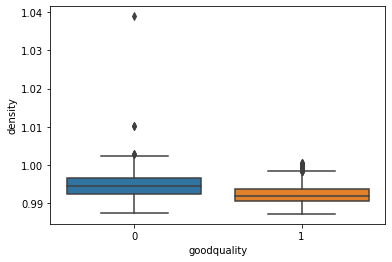

In [40]:
sns.boxplot(x="goodquality", y="density", data=df_bin_label)

Good quality wines have a lower IQR and median than bad quality ones.

## Preprocessing

I will perform processing on the dataset for the supervised machine learning algorithms in the following steps:
1. Feature Engineering
2. Handling imblanced classes
3. Scaling features (Done in Supervised Learning section)
4. Creating sklearn pipeline (Done in Supervised Learning section)

### Feature Engineering
I will use sklearn's PolynomialFeatures with degree = 2 to determine if the creation of additional features will be useful through their correlations.

In [10]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df.drop(["density", "quality"], axis=1))

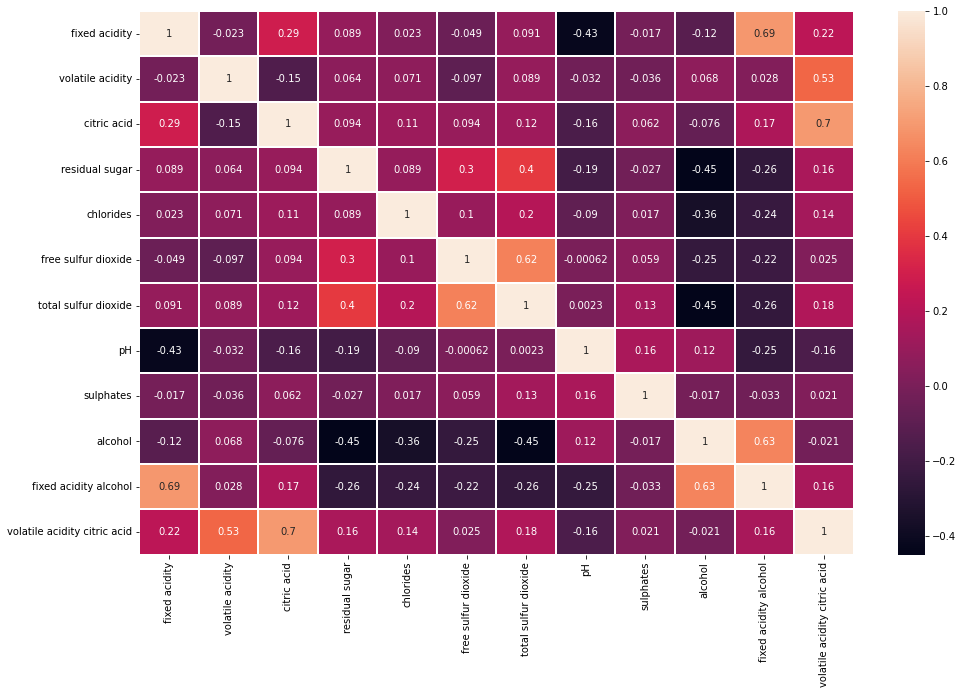

In [54]:
plt.figure(figsize=(16, 10))

df_poly = pd.DataFrame(columns=poly.get_feature_names_out(), data=X_poly)
correlation_matrix_poly = df_poly.corr().abs()

# Create and select upper triangle matrix
upper_tri = correlation_matrix_poly.where(
    np.triu(np.ones(correlation_matrix_poly.shape), k=1).astype(np.bool)
)

# Drop high correlation columns
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.70)]
to_drop = to_drop + ["1"]
df_poly_filter = df_poly.drop(df_poly[to_drop], axis=1)

# View correlation heatmap
sns.heatmap(df_poly_filter.corr(), annot=True, linewidths=0.2)
plt.show()

Based on PolynomialFeatures, and filtering out features with high positive correlations of greater than 0.7 with one another, there are 2 remaining features created. These are `fixed acidity alcohol` and `volatile acidity citric acid`. Observing the descriptions between these two pairs of features, it can be rationally explained as a mathematical feasibility, however further subject expertise is needed. I will go ahead and keep these two new features in the pipeline below.

Since there are three different types of acidity present in the dataset, I will also create a new feature called 'total acidity' from the sum of each acidity columns.

With white wines being available in many types of robust flavours, I found this [article](https://vinepair.com/articles/what-is-a-crisp-wine/) that describes what a crisp wine is. Thus I have created a 'crisp wine' feature from the 'total acidity' and 'residual sugar' columns.

In [7]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    """This class is used for feature engineering to create four
    additional new features. It is to be used as a part of the
    pipeline.
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Perform feature transformation
        X["total acidity"] = (
            X["citric acid"] + X["fixed acidity"] + X["volatile acidity"]
        )
        X["crisp ratio"] = X["total acidity"] / X["residual sugar"]
        X["fixed acidity alcohol"] = X["fixed acidity"] * X["alcohol"]
        X["volatile acidity citric acid"] = X["volatile acidity"] * X["citric acid"]
        return X

    # Hard code feature names
    def get_feature_names_out(self, input_features=None):
        feature_names = [
            "fixed acidity",
            "volatile acidity",
            "citric acid",
            "residual sugar",
            "chlorides",
            "free sulfur dioxide",
            "total sulfur dioxide",
            "pH",
            "sulphates",
            "alcohol",
            "total acidity",
            "crisp ratio",
            "fixed acidity alcohol",
            "volatile acidity citric acid",
        ]
        return feature_names

### Train-Test Split

In [9]:
X = df_bin_label.drop(["goodquality", "density", "quality"], axis=1)
y = df_bin_label["goodquality"]

In [9]:
# Original Dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=123
)

### Handling imbalanced classes
Across the entire dataset, currently there are approximately 3.6X more bad quality wines (3838) over good quality wines (1060). Reducing this imbalance could potentially lead to better results. There are 2 methods that can be used namely undersampling and oversampling. However, undersampling results in reducing data points of the negative class in this case which will result in a loss of training data.  

Hence for this project, I will oversample the minority positive class by approximately 1.5X. I will perform this using SMOTE to create synthetic good quality wines data. However, there will still be a class imbalance albeit at a lower ratio. To account for this imbalance, class weights in model parameters will be considered.  

In addition, SMOTE will only be performed on the training dataset to prevent data leakage.

<AxesSubplot:xlabel='residual sugar', ylabel='chlorides'>

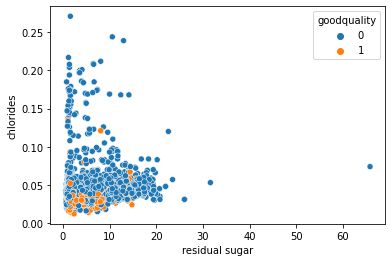

In [13]:
# Original data

# The features fixed acidity and chlorides are able to
# separate the labels relatively well as from the pairplot diagram
sns.scatterplot(data=X_train, x="residual sugar", y="chlorides", hue=y_train)

In [10]:
X_train.shape, y_train.shape

((3428, 10), (3428,))

In [11]:
y_train.value_counts()

0    2686
1     742
Name: goodquality, dtype: int64

#### SMOTE

In [12]:
oversample = SMOTE(sampling_strategy=0.4)
X_train_sm, y_train_sm = oversample.fit_resample(X_train.copy(), y_train)

<AxesSubplot:xlabel='residual sugar', ylabel='chlorides'>

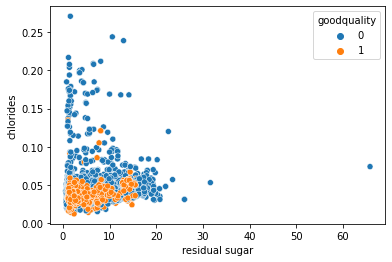

In [13]:
sns.scatterplot(data=X_train_sm, x="residual sugar", y="chlorides", hue=y_train_sm)

In [14]:
X_train_sm.shape, y_train_sm.shape

((3760, 10), (3760,))

In [15]:
y_train_sm.value_counts()

0    2686
1    1074
Name: goodquality, dtype: int64

It can be observed that the new synthetic data points are close to the original data points with respect to the good quality class. Using SMOTE has reduced the imbalance from 3.6X to 2.5X and 332 new synthetic data points have been created in the training dataset.  

The SMOTE dataset will be evaluated against the original for the supervised learning task.

## Unsupervised Learning

As a baseline, I will perform clusering using a K-Means algorithm on the complete original dataset without the label column.  
I will also apply PCA to the features and test the K-Means clustering and GMM on the principal components.  

In [86]:
# Drop label column
df_usl = df.drop(["quality"], axis=1)

scaler = StandardScaler()
X_df = scaler.fit_transform(df_usl)

### K-Means Modelling

Initially I will perform K-Means clustering on the standarsized original dataset.

#### Elbow Method

Text(0, 0.5, 'SSE')

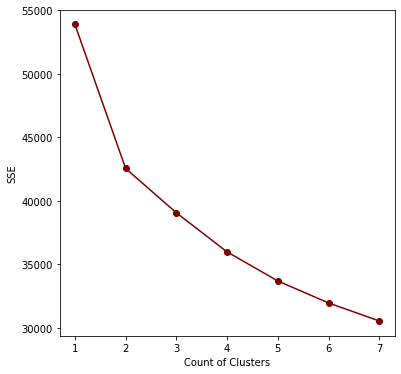

In [11]:
# elbow method to identify optimal value of K
sse = []
for k in range(1, 8):
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(X_df)
    sse.append(km.inertia_)

# plot to identify the elbow
plt.figure(figsize=(6, 6))
plt.plot(range(1, 8), sse, "-o", c="maroon")
plt.xlabel("Count of Clusters")
plt.ylabel("SSE")

It seems that the elbow in the graph above kinks at 2, which is also the number of ground truth labels.  
Thus, I will pick for there to be 2 clusters.

In [12]:
kmeans = KMeans(n_clusters=2, random_state=123)
kmeans.fit(X_df)
y_kmeans = kmeans.predict(X_df)

I will explore the scatter plot of clusters across all features against one another to determine the optimal two features that show a separation of clusters.

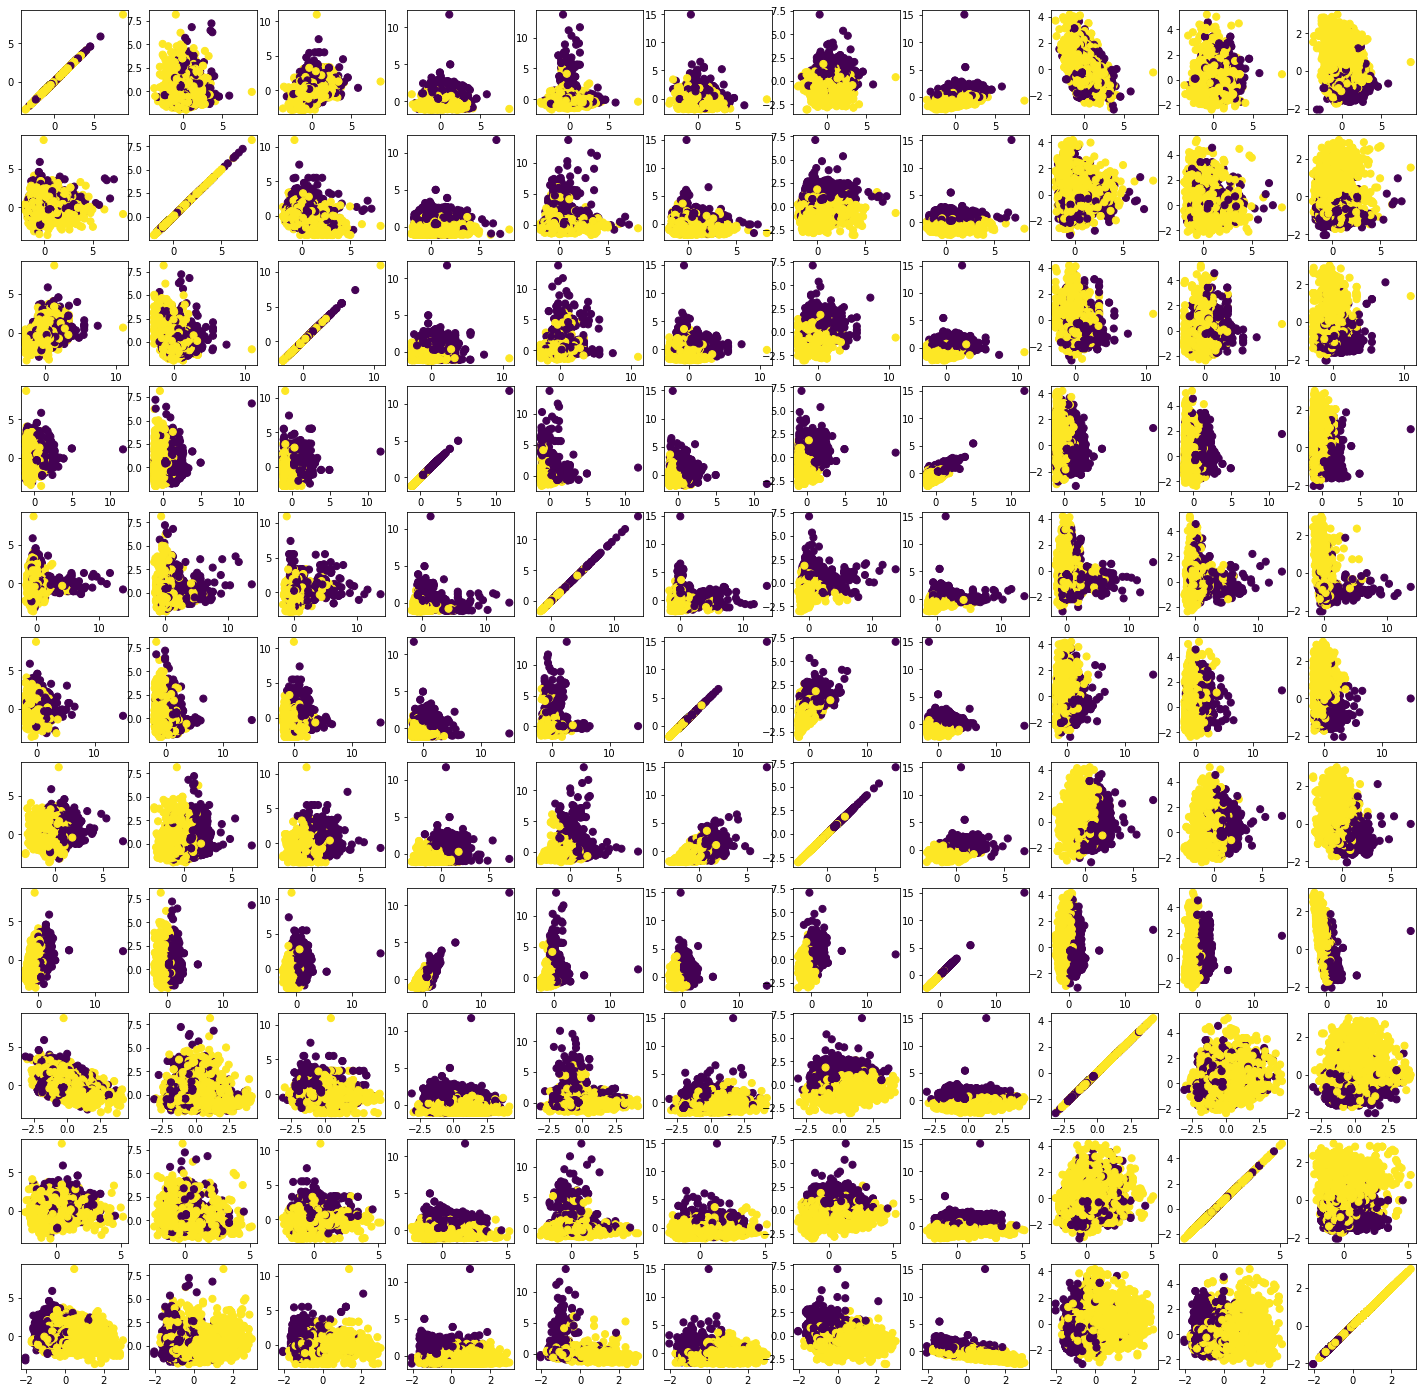

In [13]:
count = 1
plt.subplots(figsize=(25, 25))
for i, j in enumerate(df_usl.columns):
    for k, l in enumerate(df_usl.columns):
        plt.subplot(11, 11, count)
        plt.scatter(X_df[:, i], X_df[:, k], c=y_kmeans, s=50, cmap="viridis")
        count += 1

plt.show()

It seems the sixth and seventh features enable better cluster visualization.

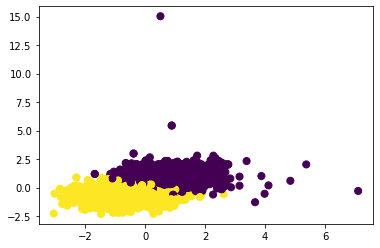

In [14]:
plt.scatter(X_df[:, 6], X_df[:, 7], c=y_kmeans, s=50, cmap="viridis")

Using these two features, the clustering can be well identified.

### PCA

I will perform PCA to identify the principal components of the dataset.

In [15]:
pca = PCA()  # Utilizing default hyperparameters
pca.fit(X_df)

PCA()

In [16]:
exp_var_pca = pca.explained_variance_ratio_
print(exp_var_pca)

[0.29293217 0.14320363 0.11106103 0.09259294 0.08848496 0.08534014
 0.06605437 0.05448713 0.03764942 0.02631701 0.00187719]


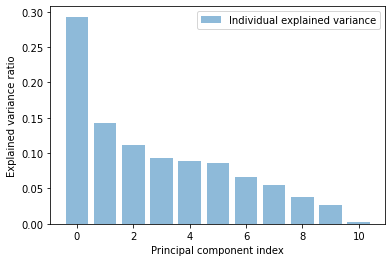

In [17]:
plt.bar(
    range(0, len(exp_var_pca)),
    exp_var_pca,
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.show()

It seems the first principal component explains a majority of the variance. For this analysis, I will pick the first 2 components.  
Below, I visualize the features in the first two components.

Text(0.5, 1.0, 'Second Principal Component Axis')

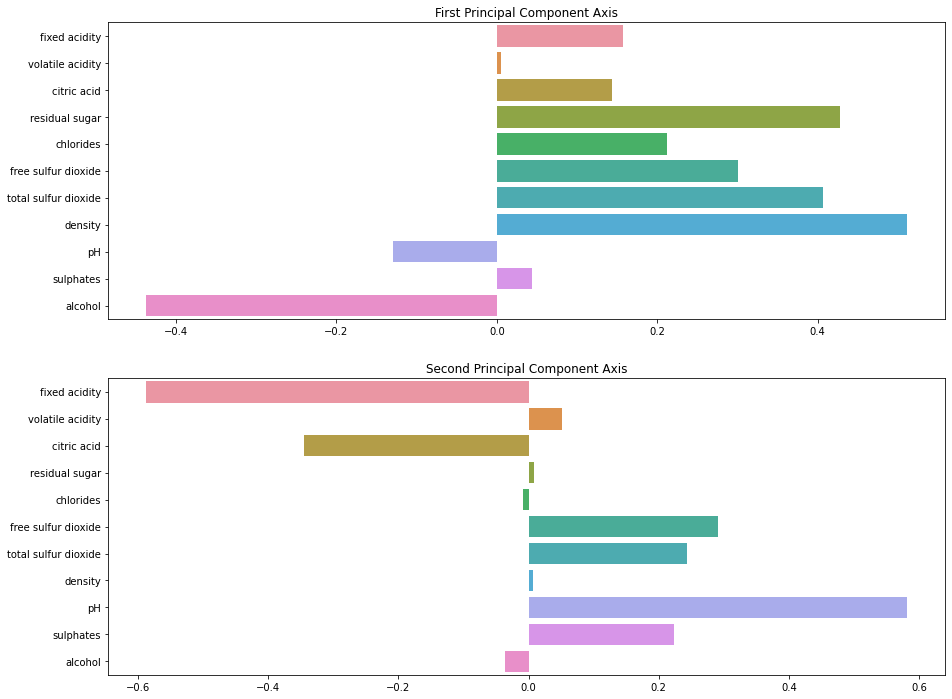

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
sns.barplot(x=pca.components_[0], y=df_usl.columns, orient="h", ax=ax[0])
sns.barplot(x=pca.components_[1], y=df_usl.columns, orient="h", ax=ax[1])

ax[0].set_title("First Principal Component Axis")
ax[1].set_title("Second Principal Component Axis")

The first two components of PCA are linearly related with the different numerical features and capture a wide varity of variances.  
In the first principal component, the feature 'density' has the highest variance and this can be understood based on its high correlation with 'residual_sugar' and 'alcohol'.

### KMeans on PCA dataset

In [19]:
X_pca = PCA(n_components=2).fit_transform(X_df)

In [20]:
kmeans_pca = KMeans(n_clusters=2, random_state=123)
y_kmeans_pca = kmeans_pca.fit_predict(X_pca)

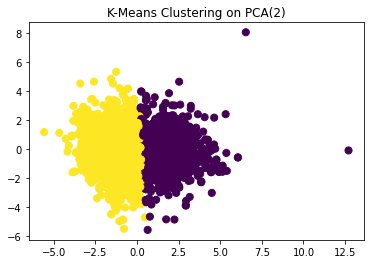

In [21]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans_pca, s=50, cmap="viridis")
plt.title("K-Means Clustering on PCA(2)")
plt.show()

The PCA process enables the clusters to be very clearly distinguised. Thus wines of higher quality can be potentially identified based on the clusters.

### Gaussian Mixture Model

In [22]:
gmm = GaussianMixture(n_components=2, random_state=123)

In [23]:
gmm.fit(X_df)

GaussianMixture(n_components=2, random_state=123)

In [24]:
# Predictions from gmm
y_gmm = gmm.predict(X_df)

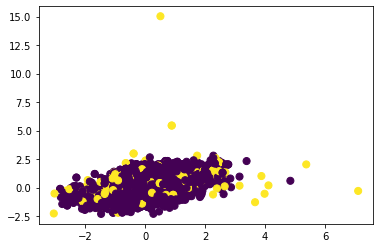

In [25]:
plt.scatter(X_df[:, 6], X_df[:, 7], c=y_gmm, s=50, cmap="viridis")

Using the GMM, the clusters are highly intermingled.

### GMM on PCA dataset

In [26]:
gmm = GaussianMixture(n_components=2, random_state=123)
y_gmm_pca = gmm.fit_predict(X_pca)

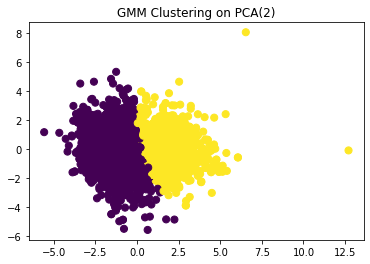

In [27]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_gmm_pca, s=50, cmap="viridis")
plt.title("GMM Clustering on PCA(2)")
plt.show()

GMM clustering on the PCA dataset results in the clusters being separated clearly.

### Comparing Clusters to Ground Truth Labels
The ground truth label contains a class imbalance with there being fewer good quality wines.  
Exploring the value counts of the clusters,

In [28]:
np.bincount(y_kmeans)

array([1957, 2941], dtype=int64)

In [29]:
np.bincount(y_kmeans_pca)

array([1984, 2914], dtype=int64)

In [30]:
np.bincount(y_gmm)

array([4392,  506], dtype=int64)

In [31]:
np.bincount(y_gmm_pca)

array([2955, 1943], dtype=int64)

In [32]:
y.value_counts()

0    3838
1    1060
Name: goodquality, dtype: int64

The predicted clusters contain differing ratios with respect to the classes of the ground truth label.  
In the ground truth, the majority class is 'not good' wines, thus I will take the majority class of each clustering method to mean 'not good'.  
For the K-Means clustering, the majority class is at index 1, thus I will map it to index 0.

In [138]:
def k_means_class_mapping(label):
    """Maps labels from 0 to
    1 and vice versa.
    """
    if label == 0:
        new_label = 1
    if label == 1:
        new_label = 0
    return new_label

In [139]:
y_kmeans_map = list(map(k_means_class_mapping, y_kmeans))
y_kmeans_pca_map = list(map(k_means_class_mapping, y_kmeans_pca))

#### Clusters Means
One rudimentary method to compare clusters to the original classes is to compare their respective means. In this section, I compare the means for each class with respect to each clustering method against the original dataset.

In [93]:
feature_cols = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]

In [95]:
def cluster_mean(cluster_pred, df, label):
    """Fetches feature means by label from dataframe.

    Retrieves means of all features from .describe()
    call on a dataframe filtered by the given label.

    Args:
        cluster_pred (array, list): Clustering algorithm
            predictions.
        df (pd.dataframe): Original dataframe used for unsupervised
            learning.
        label (int): Clustering prediction class label.

    Returns:
        means (pd.dataframe): Means of all features filtered by
            respective label.
    """
    df = df.copy()
    df["cluster"] = cluster_pred
    means = df[df["cluster"] == label].describe().loc[["mean"]][feature_cols]
    return means.head()

**Cluster = 0**  
Not good wines

In [112]:
df_notgoodquality.describe().loc[["mean"]][feature_cols]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
mean,6.890594,0.281802,0.336438,6.703478,0.047875,35.517327,141.982934,0.994474,3.180847,0.487004,10.265215


In [140]:
cluster_mean(y_kmeans_map, df_usl, 0)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
mean,6.756018,0.275097,0.315332,3.529633,0.039982,28.549473,116.709963,0.992142,3.208514,0.485301,11.161775


In [141]:
cluster_mean(y_kmeans_pca_map, df_usl, 0)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
mean,6.742776,0.275182,0.315017,3.536771,0.03988,28.538778,116.294784,0.992122,3.208902,0.484708,11.172368


In [115]:
cluster_mean(y_gmm, df_usl, 0)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
mean,6.856683,0.2658,0.325585,6.331125,0.042105,34.758197,137.148452,0.993884,3.192657,0.492284,10.601324


In [116]:
cluster_mean(y_gmm_pca, df_usl, 0)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
mean,6.785296,0.276005,0.318227,3.573519,0.040148,28.358545,116.400338,0.992167,3.2042,0.483201,11.159587


The Gaussian Mixture Model (GMM) trained on the original-scaled dataset is able to cluster the 'not good' wines class relatively well. The means of its features' clusters are close to the original datasets'.

**Cluster = 1**  
Good wines

In [117]:
df_goodquality.describe().loc[["mean"]][feature_cols]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
mean,6.725142,0.265349,0.326057,5.261509,0.03816,34.550472,125.245283,0.992412,3.215132,0.500142,11.416022


In [118]:
cluster_mean(y_kmeans_map, df_usl, 1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
mean,7.003219,0.282966,0.362534,10.692131,0.054475,45.464997,170.897547,0.996861,3.157839,0.496679,9.541185


In [119]:
cluster_mean(y_kmeans_pca_map, df_usl, 1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
mean,7.019304,0.282734,0.362354,10.584173,0.054427,45.250504,170.769909,0.996825,3.157959,0.497394,9.547681


In [120]:
cluster_mean(y_gmm, df_usl, 1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
mean,6.83834,0.386225,0.408893,6.914723,0.077605,40.081028,148.882411,0.99527,3.150158,0.468696,9.75863


In [121]:
cluster_mean(y_gmm_pca, df_usl, 1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
mean,6.960473,0.281642,0.358471,10.676994,0.054326,45.877252,171.758878,0.996857,3.164035,0.499954,9.532836


Based on the feature importance below, the `alcohol` feature is the most important for the supervised task. For good wines, all four clustering methods' alcohol content levels vary drastically from the original cluster mean. The values for 'total sulfur dioxide', and 'free sulfur dioxide' for all clustering types also lie a distance away from the original means. Despite all the poor comparisons, the Gaussian Mixture Model (GMM) trained on the original-scaled dataset has the closest means to the original.  

Thus the GMM could be considered for differentiating good wines from the rest.

#### Adjusted Rand Score
The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. Further information can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html).

In [133]:
print(
    f"Adjusted Rand Index for K-Means on original dataset: \t{adjusted_rand_score(y, y_kmeans_map)}"
)
print(
    f"Adjusted Rand Index for K-Means on PCA dataset: \t{adjusted_rand_score(y, y_kmeans_pca_map)}"
)
print(
    f"Adjusted Rand Index for GMM on original dataset: \t{adjusted_rand_score(y, y_gmm)}"
)
print(
    f"Adjusted Rand Index for GMM on PCA dataset: \t{adjusted_rand_score(y, y_gmm_pca)}"
)

Adjusted Rand Index for K-Means on original dataset: 	-0.006532407130778724
Adjusted Rand Index for K-Means on PCA dataset: 	-0.0034801222336937575
Adjusted Rand Index for GMM on original dataset: 	-0.07893032420619775
Adjusted Rand Index for GMM on PCA dataset: 	-0.008703017901833584


Based on the documentation, a value close to 0 implies random labelling. This hints that the class members are completely split across different clusters and the assignment is incomplete, hence the low ARI score. Thus, the GMM trained on the original-scaled dataset has the better performance over the K-Means algorithm.

#### V-Measure Score
The V-measure score is the harmonic mean of the homogeneity and completeness for cluster assignment. It is calculated using conditional entropy analysis. Futher information can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html).

In [142]:
print(
    f"V-measure for K-Means on original dataset: \t{v_measure_score(y, y_kmeans_map)}"
)
print(f"V-measure for K-Means on PCA dataset: \t{v_measure_score(y, y_kmeans_pca_map)}")
print(f"V-measure for GMM on original dataset: \t{v_measure_score(y, y_gmm)}")
print(f"V-measure for GMM on PCA dataset: \t{v_measure_score(y, y_gmm_pca)}")

V-measure for K-Means on original dataset: 	0.05368043517169727
V-measure for K-Means on PCA dataset: 	0.05497965636251239
V-measure for GMM on original dataset: 	0.03761062775228206
V-measure for GMM on PCA dataset: 	0.05063461537822483


As the V-measure scores are very low, it seems that the class members are completely split across different clusters and thus the assignment is totally incomplete. This is because clusters that include samples from different classes destroy the homogeneity of the labelling.

#### Balanced Accuracy

In [136]:
print(
    f"Balanced accuracy for K-Means on original dataset: \t{round(balanced_accuracy_score(y, y_kmeans_map), 3)}"
)
print(
    f"Balanced accuracy for K-Means on PCA dataset: \t{round(balanced_accuracy_score(y, y_kmeans_pca_map), 3)}"
)
print(
    f"Balanced accuracy for GMM on original dataset: \t{round(balanced_accuracy_score(y, y_gmm), 3)}"
)
print(
    f"Balanced accuracy for GMM on PCA dataset: \t{round(balanced_accuracy_score(y, y_gmm_pca), 3)}"
)

Balanced accuracy for K-Means on original dataset: 	0.356
Balanced accuracy for K-Means on PCA dataset: 	0.353
Balanced accuracy for GMM on original dataset: 	0.444
Balanced accuracy for GMM on PCA dataset: 	0.36


The GMM clustering on the original-scaled dataset have the highest balanced accuracy scores.

#### F1 score

In [137]:
print(
    f"F1 score for K-Means on original dataset: \t{round(f1_score(y, y_kmeans_map), 3)}"
)
print(
    f"F1 score for K-Means on PCA dataset: \t{round(f1_score(y, y_kmeans_pca_map), 3)}"
)
print(f"F1 score for GMM on original dataset: \t{round(f1_score(y, y_gmm), 3)}")
print(f"F1 score for GMM on PCA dataset: \t{round(f1_score(y, y_gmm_pca), 3)}")

F1 score for K-Means on original dataset: 	0.122
F1 score for K-Means on PCA dataset: 	0.122
F1 score for GMM on original dataset: 	0.02
F1 score for GMM on PCA dataset: 	0.125


The GMM model on the scaled-PCA dataset has the highest F1 score.

Thus based on this overall evaluation with the ground truth label, the Gaussian Mixture Model algorithm could be potentially used to cluster good white wines.

## Supervised Learning
In this section, I will explore supervised learning methods on the dataset and the label is available. I will utilize four differing models to test their capability on identifying the good quality white wines. The four models are:
1. Logistic Regression
2. Support Vector Machine Classifier
3. Random Forest Classifier
4. Artificial Shallow Neural Network  

As the dataset is imbalanced, I will utilize each model's class_weight paramter and enable it to 'balanced'. This method automatically adjusts weights inversely proportional to class frequencies in the input data.

In [16]:
# create DataFrame to store results
supervised_results_df = pd.DataFrame(
    columns=["model", "smote", "cv_f1_score", "test_bal_acc", "test_f1_score"]
)

As I utilize class weights during training of the Artificial Neural Network (ANN), I decided to use the Accuracy class from keras.metrics during compiling the model. Since the dataset is not complex, I will utilize 2 hidden layers.

In [17]:
def nn_model():
    # Create model
    model = Sequential()
    model.add(Dense(16, input_dim=14, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    # Compile model
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [18]:
nn_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                240       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


I utilized the 'linear' kernel for the SVC model because the feature coefficient weights can be explored.

In [19]:
model_classes = [
    ["log_reg", LogisticRegression(class_weight="balanced", random_state=123)],
    ["svc", svm.SVC(kernel="linear", class_weight="balanced", random_state=123)],
    [
        "rfc",
        RandomForestClassifier(max_depth=2, class_weight="balanced", random_state=123),
    ],
    ["ann", KerasClassifier(build_fn=nn_model, epochs=10, batch_size=64)],
]

During the initial run of the model training, I used the the "roc_auc" metric when performing cross validation for model selection. As the dataset has some imbalance, ROC is a metric that has good performance of distinguishing between the positive and negative class. Upon execution, the ROC_AUC scores were high between the ranges of 0.8 - 0.85 for all models. Upon further examination, I noticed that the False Positive rate was very high. In view of this, as the positive class is the focus for prediction, I will use the "f1_score" for cross validation.

In [20]:
def modelling(model, X_train, y_train, X_test, y_test, smote=False):
    """Creates sklearn pipeline with args provided and performs
    supervised learning model training on pipeline.

    Args:
        model (estimator): Supervised learning model.
        X_train (pd.dataframe): Training features.
        y_train (pd.dataframe): Training labels.
        X_test (pd.dataframe): Test features.
        y_test (pd.dataframe): Test labels.
        smote (bool, default=False): Boolean that indicates if the 
            training dataset has synthetically created data points.

    Returns:
        pipe (sklearn.pipeline): A fit sklearn pipeline corresponding
            to the args provided.
    """

    print(f"processing model: {str(model)}")

    if smote:
        smote_col = "Y"
    else:
        smote_col = "N"

    # update class_weights for neural network
    if "KerasClassifier" in str(model):
        class_weights = compute_class_weight(
            class_weight="balanced", classes=np.unique(y_train), y=y_train
        )
        class_weights = dict(enumerate(class_weights))
        model.set_params(class_weight=class_weights)

    pipe = make_pipeline(CustomTransformer(), StandardScaler(), model)
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    bal_acc_test = balanced_accuracy_score(y_test, y_pred)
    f1_score_test = f1_score(y_test, y_pred)

    # evaluate pipeline
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    cv_scores = cross_val_score(pipe, X_train, y_train, scoring="f1", cv=cv, n_jobs=-1)

    eval_output = [
        str(model),
        smote_col,
        np.mean(cv_scores),
        bal_acc_test,
        f1_score_test,
    ]

    # add results to dataframe
    supervised_results_df.loc[len(supervised_results_df)] = eval_output

    return pipe

Training takes betweeen 5-10 minutes depending on your system. Results may vary at runtime.  
Model files and pipeline objects (with the exception of ANNs) have been pickled and can be loaded in the evaluation section. This is so as the ANN itself can't be pickled and dumped.

In [21]:
%%time

fitted_models = {}
for model_name, model in model_classes:
    model1 = clone(model)
    model2 = clone(model)

    # train model on original dataset
    pipe1 = modelling(model1, X_train.copy(), y_train, X_test.copy(), y_test)
    fitted_models[model_name] = pipe1

    # train models on smote dataset
    pipe2 = modelling(
        model2, X_train_sm.copy(), y_train_sm, X_test.copy(), y_test, smote=True
    )
    fitted_models[model_name + "_sm"] = pipe2

processing model: LogisticRegression(class_weight='balanced', random_state=123)
processing model: LogisticRegression(class_weight='balanced', random_state=123)
processing model: SVC(class_weight='balanced', kernel='linear', random_state=123)
processing model: SVC(class_weight='balanced', kernel='linear', random_state=123)
processing model: RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=123)
processing model: RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=123)
processing model: <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000025988620D90>
Epoch 1/10
54/54 [==============================] - 2s 6ms/step - loss: 0.7096 - accuracy: 0.7789
Epoch 2/10
54/54 [==============================] - 0s 8ms/step - loss: 0.6399 - accuracy: 0.7757
Epoch 3/10
54/54 [==============================] - 0s 9ms/step - loss: 0.6140 - accuracy: 0.7856
Epoch 4/10
54/54 [==============================] - 1s 11ms/step - loss: 0.5960 - accuracy: 0.7

In [22]:
fitted_models

{'log_reg': Pipeline(steps=[('customtransformer', CustomTransformer()),
                 ('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(class_weight='balanced',
                                     random_state=123))]),
 'log_reg_sm': Pipeline(steps=[('customtransformer', CustomTransformer()),
                 ('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(class_weight='balanced',
                                     random_state=123))]),
 'svc': Pipeline(steps=[('customtransformer', CustomTransformer()),
                 ('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(class_weight='balanced', kernel='linear',
                      random_state=123))]),
 'svc_sm': Pipeline(steps=[('customtransformer', CustomTransformer()),
                 ('standardscaler', StandardScaler()),
                 ('svc',
              

Save Pipelines and Results

In [26]:
# Save fitted_models dict as a pickle file

fitted_models_wo_ann = fitted_models.copy()
for key in ["ann", "ann_sm"]:
    del fitted_models_wo_ann[key]

joblib.dump(fitted_models_wo_ann, "output/fitted_models_wo_ann_pipeline.pkl")

['fitted_models_wo_ann_pipeline.pkl']

In [27]:
supervised_results_df.to_csv("output/supervised_results.csv")

To load pipelines and results, uncomment cells below and execute.  
_Note: ensure that the functions in the pipeline have been initialized prior_

In [14]:
# fitted_models = joblib.load("output/fitted_models_wo_ann_pipeline.pkl")

In [53]:
# supervised_results_df = pd.read_csv('output/supervised_results.csv', index_col=0)

In [54]:
supervised_results_df

,model,smote,cv_f1_score,test_bal_acc,test_f1_score
0,"LogisticRegression(class_weight='balanced', ra...",N,0.525143,0.722132,0.521097
1,"LogisticRegression(class_weight='balanced', ra...",Y,0.606116,0.715679,0.514226
2,"SVC(class_weight='balanced', kernel='linear', ...",N,0.542984,0.724843,0.523659
3,"SVC(class_weight='balanced', kernel='linear', ...",Y,0.619647,0.728421,0.527311
4,RandomForestClassifier(class_weight='balanced'...,N,0.529384,0.711724,0.511230
5,RandomForestClassifier(class_weight='balanced'...,Y,0.608486,0.718832,0.520788
6,<keras.wrappers.scikit_learn.KerasClassifier o...,N,0.565202,0.729290,0.528421
7,<keras.wrappers.scikit_learn.KerasClassifier o...,Y,0.660504,0.730600,0.534066


**Original dataset results**

In [55]:
supervised_results_df[supervised_results_df["smote"] == "N"].round(
    3
).style.highlight_max(color="lightgreen", axis=0)

,model,smote,cv_f1_score,test_bal_acc,test_f1_score
0,"LogisticRegression(class_weight='balanced', random_state=123)",N,0.525000,0.722000,0.521000
2,"SVC(class_weight='balanced', kernel='linear', random_state=123)",N,0.543000,0.725000,0.524000
4,"RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=123)",N,0.529000,0.712000,0.511000
6,,N,0.565000,0.729000,0.528000


Max highlighting for the 'model' and 'smote' columns can be ignored for the dataframe above and below.

When examining the scores on the original dataset, the ANN model has the best performance. However, its results are only marginally ahead of the SVC model. Scores for the Logistic Regression and RFC follow behind closely and are not too far off the top two models.

Across all the models, the results do not vary drastically and are within a close range of one another. This suggests that using a simpler model might be sufficient as feature importances can be observed.

**SMOTE dataset results**

In [56]:
supervised_results_df[supervised_results_df["smote"] == "Y"].round(
    3
).style.highlight_max(color="lightgreen", axis=0)

,model,smote,cv_f1_score,test_bal_acc,test_f1_score
1,"LogisticRegression(class_weight='balanced', random_state=123)",Y,0.606000,0.716000,0.514000
3,"SVC(class_weight='balanced', kernel='linear', random_state=123)",Y,0.620000,0.728000,0.527000
5,"RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=123)",Y,0.608000,0.719000,0.521000
7,,Y,0.661000,0.731000,0.534000


The cross validated F1 score sees a significant improvement for all models with the synthetically generated data points over the original dataset.  

Test balanced accuracy between the two datasets barely sees any substantial improvement. Surprisingly, the test balanced accuracy for the Logistic Regression model decreases with the SMOTE dataset only.

Test F1 score sees a minimal improvement with the ANN, SVC and RFC models on the SMOTE dataset. Surprisingly, the test F1 score for the Logistic Regression model decreases on the SMOTE dataset. This suggests that using the original dataset with a 'balanced' class weight is sufficient and either of Precision or Recall can be further examined over the F1 Score.

Examining across the SMOTE dataset, the ANN model has the highest scores for all the evaluation metrics. As the performance on the SMOTE dataset only sees a minor improvement over the original dataset, I will utilize the original dataset and its relevant models for further evaluation.  

The large improvement in cross validation F1 scores possibly suggests that the SMOTE dataset might result in overfitting.

### Evaluation
I will compare the evaluation of the Artificial Neural Network (ANN) and Support Vector Classifier (SVC) against one another to pick a more comprehensive model.

Label = 1 represents a good quality white wine.

#### Classification Report
of the chosen models on the original dataset,

**ANN + Original Dataset**

In [28]:
print(
    classification_report(y_test, fitted_models["ann"].predict(X_test), labels=[1, 0])
)

              precision    recall  f1-score   support

           1       0.40      0.79      0.53       318
           0       0.92      0.67      0.77      1152

    accuracy                           0.70      1470
   macro avg       0.66      0.73      0.65      1470
weighted avg       0.81      0.70      0.72      1470



**SVC + Original Dataset**

In [29]:
print(
    classification_report(y_test, fitted_models["svc"].predict(X_test), labels=[1, 0])
)

              precision    recall  f1-score   support

           1       0.39      0.78      0.52       318
           0       0.92      0.67      0.77      1152

    accuracy                           0.69      1470
   macro avg       0.66      0.72      0.65      1470
weighted avg       0.80      0.69      0.72      1470



It can be determined that the SVC and ANN models have similar Precision and Recall scores for the Positive class.  
The Accuracy metric in this scenario does not result in a high score and might be a misleading as there is an imbalance in the data. 

#### Confusion Matrix
of the chosen models on the original dataset,

**ANN + Original Dataset**

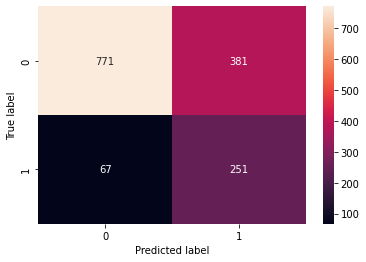

In [31]:
cm = confusion_matrix(y_test, fitted_models["ann"].predict(X_test), labels=[0, 1])
f = sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

**SVC + Original Dataset**

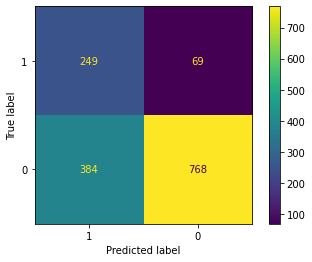

In [32]:
plot_confusion_matrix(fitted_models["svc"], X_test, y_test, labels=[1, 0])

Both models trained on the original dataset have a higher number of False Positives over True Positives on the test set. Between these two models, they have a comparable number of True Positives whereas the ANN model has a slightly higher number of True Negatives. The False Negatives for both the ANN and SVC models are comparable.  

In this project's context, a false positive is to mean that the model predicted a particular white wine to be of good quality when in fact it is not. The cost attached to this prediction might not be high in practicality however it could be detrimental for expensive and collector's editions of wines or during wine championships. Having a cost-benefit matrix and evaluating the expected value of the predictions might help with assessing the context of predictions from the confusion matrix.

As there is a high number of False Positives, prioritising Recall over Precision for the positive class should be considerd for model evaluation. In this case of predicting a good quality white wine, Recall means out of how many of the good quality white wines, were we able to identify correctly as good quality.

#### Feature Importances
As the ANN and SVC models have comparable results, I will explore the feature importances of the SVC model trained on the original dataset.

Text(0.5, 1.0, 'Feature Importance')

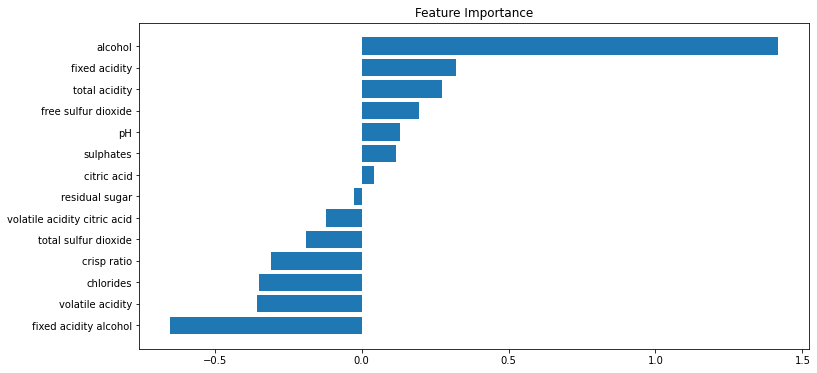

In [33]:
feature_importance = fitted_models["svc"]["svc"].coef_.ravel()
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(
    range(len(sorted_idx)),
    np.array(fitted_models["svc"]["customtransformer"].get_feature_names_out())[
        sorted_idx
    ],
)
plt.title("Feature Importance")

The `alcohol` content feature plays a highly important role in this classification task.  

The sum of the acidity features becomes the third highest important feature, this can be attributed to `fixed acidity` contributing its own importance. The feature `crisp ratio` has a negative score, thus suggesting its not very useful.

The two polynomialn features that were created played some importance for the predictive model when making a prediction. It is interesting to note that despite `alcohol` and `fixed acidity` having the top two highest feature importance scores, their product feature has the lowest importance score, thus suggesting that this product feature contributes for the loss to increase.  

Feature selection for the top 6 importances could be sufficient to create a model with good performance.

### Hyperparameter Tuning
I will select the SVC model to be trained on the original dataset and find its optimal hyperparameters. When initially running the GridSearchCV, it took a very long time to execute often going for over two hours with no completion. In view of this, I have decided to utilize an experimental feature in scikit-learn called [HalvingGridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html#sklearn.model_selection.HalvingGridSearchCV). Further information can be found [here](https://scikit-learn.org/stable/modules/grid_search.html#successive-halving-user-guide).

For the tuned model, I explore additional evaluations such as:
- PR Curve
- ROC Curve
- AUROC
- Prediction Thresholds

#### GridSearchCV & Evaluation

In [41]:
%%time

param_grid = {
    "svc__kernel": ["linear", "poly", "rbf"],
    "svc__C": [0.1, 1, 10],
    "svc__class_weight": [None, "balanced"],
    "svc__gamma": [1, 0.1, 0.01],
}

pipeline_svm = make_pipeline(
    CustomTransformer(), StandardScaler(), svm.SVC(probability=True, random_state=123)
)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
grid = HalvingGridSearchCV(
    pipeline_svm,
    param_grid,
    scoring="f1",
    cv=folds,
    random_state=123,
    n_jobs=-1,
    verbose=2,
)

# fitting the model for grid search
grid.fit(X_train.copy(), y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 126
max_resources_: 3428
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 126
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 18
n_resources: 378
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 6
n_resources: 1134
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 3402
Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 5.19 s
Wall time: 33.1 s


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                    estimator=Pipeline(steps=[('customtransformer',
                                               CustomTransformer()),
                                              ('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(probability=True,
                                                   random_state=123))]),
                    n_jobs=-1,
                    param_grid={'svc__C': [0.1, 1, 10],
                                'svc__class_weight': [None, 'balanced'],
                                'svc__gamma': [1, 0.1, 0.01],
                                'svc__kernel': ['linear', 'poly', 'rbf']},
                    random_state=123, scoring='f1', verbose=2)

In [42]:
# Finding best hyperparameters
print(f"Best Hyperparameters: \n{grid.best_params_}\n")
print(f"Mean CV Score of the best estimator: {round(grid.best_score_, 3)}")

Best Hyperparameters: 
{'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

Mean CV Score of the best estimator: 0.554


In [43]:
# Score on test dataset
grid_predictions = grid.predict(X_test.copy())
print(
    f"Grid Search F1 Score on Test data: {round(f1_score(y_test, grid_predictions), 3)}"
)

Grid Search F1 Score on Test data: 0.529


In [44]:
print(classification_report(y_test, grid_predictions, labels=[1, 0]))

              precision    recall  f1-score   support

           1       0.40      0.77      0.53       318
           0       0.92      0.68      0.78      1152

    accuracy                           0.70      1470
   macro avg       0.66      0.73      0.66      1470
weighted avg       0.80      0.70      0.73      1470



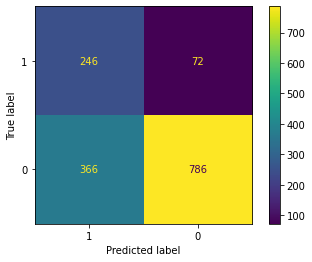

In [45]:
plot_confusion_matrix(grid, X_test.copy(), y_test, labels=[1, 0])

With the hyperparameter tuning:
- the F1 score for the positive class increases marginally
- the number of False Positives decreses slightly
- the Precision and Recall scores for the positive class remain somewhat constant

This highlights that the `rbf` kernel outputs better performance.

#### Precision Recall Curve

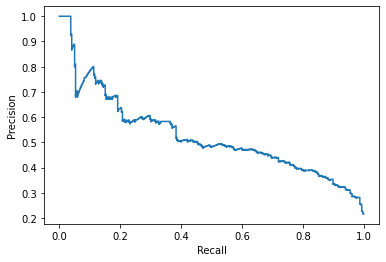

In [46]:
predictions = grid.predict_proba(X_test.copy())[:, 1]
precision, recall, _ = precision_recall_curve(y_test, predictions)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

#### ROC Curve

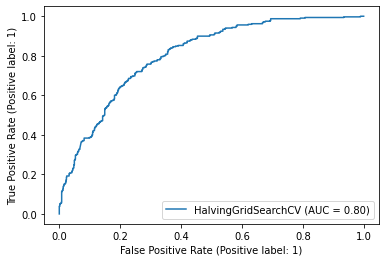

In [47]:
RocCurveDisplay.from_estimator(grid, X_test.copy(), y_test, pos_label=1)

##### AUROC Score

In [49]:
print(f"Area under ROC score: {round(roc_auc_score(y_test, predictions), 3)}")

Area under ROC score: 0.805


#### Prediction Threshold
As there is a high number of False Positives (FP) despite fine-tuning the SVC model with different models, I will explore the use of varying the prediction threshold to help reduce the FP.

In [50]:
# define thresholds
thresholds = np.arange(0, 1, 0.001)

In [51]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype("int")

In [52]:
# evaluate each threshold
scores = [f1_score(y_test, to_labels(predictions, t)) for t in thresholds]

In [53]:
# get best threshold
ix = np.argmax(scores)
print("Threshold=%.3f, F-Score=%.5f" % (thresholds[ix], scores[ix]))

Threshold=0.286, F-Score=0.54637


Using a new threshold value seems to increase the F1 score marginally.

In [54]:
scores = grid.decision_function(X_test.copy())
y_pred_2 = scores > 0.286

In [55]:
print(classification_report(y_test, y_pred_2, labels=[1, 0]))

              precision    recall  f1-score   support

           1       0.45      0.69      0.55       318
           0       0.90      0.76      0.83      1152

    accuracy                           0.75      1470
   macro avg       0.67      0.73      0.69      1470
weighted avg       0.80      0.75      0.77      1470



In [57]:
confusion_matrix(y_test, y_pred_2, labels=[1, 0])

array([[221,  97],
       [272, 880]], dtype=int64)

Using the new threshold, the number of False Positives has decreased dramatically while concurrently the number of True Negatives has increased considerably. The new threshold value also results in an increase in the Precision score for the positive class, however the Recall score for this class decreases.  

These results suggest that moving the threshold is a good way to improve and generalize the model's performance.

## Further Improvement
- Train an AutoEncoder model on the 'bad' quality wines to identify the latent space and use this to filter out the 'good' quality wines from the reconstructions based on a threshold value
- Hyperopt for hyperparameter tuning
- Serve model predictions